In [1]:
import pandas as pd
import numpy as np
from konlpy.tag import Mecab
from collections import Counter
import operator
import matplotlib.pyplot as plt
%matplotlib inline

mecab = Mecab()

In [2]:
tb1 = pd.read_csv("ratings_train.txt",sep='\t')

In [3]:
tb1.iloc[:10]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


In [4]:
keywords = [mecab.morphs(str(i).strip()) for i in tb1['document']]

In [5]:
np.median([len(k) for k in keywords]), len(keywords), tb1.shape

(14.0, 150000, (150000, 3))

In [6]:
keyword_cnt = Counter([i for item in keywords for i in item])

In [7]:
keyword_clip = sorted(keyword_cnt.items(), key=operator.itemgetter(1))[-5000:]

In [8]:
keyword_clip_dict = dict(keyword_clip)
keyword_dict = dict(zip(keyword_clip_dict.keys(), range(len(keyword_clip_dict))))

In [9]:
keyword_dict['_PAD_'] = len(keyword_dict)
keyword_dict['_UNK_'] = len(keyword_dict)

In [10]:
keyword_rev_dict = dict([(v,k) for k, v in keyword_dict.items()])

In [11]:
max_seq = np.median([len(k) for k in keywords]) + 5

In [12]:
def encoding_and_padding(corp_list, dic, max_seq=50):
    from keras.preprocessing.sequence import pad_sequences
    coding_seq = [ [dic.get(j, dic['_UNK_']) for j in i] for i in corp_list ]
    return(pad_sequences(coding_seq, maxlen=max_seq, padding='pre', truncating='pre', value=dic['_PAD_']))

In [13]:
train_x = encoding_and_padding(keywords, keyword_dict, max_seq=int(max_seq))

Using TensorFlow backend.


In [14]:
train_y = tb1['label']

In [15]:
train_x.shape, train_y.shape

((150000, 19), (150000,))

In [16]:
from keras.models import *
from keras.layers import *
from keras.utils import *
from keras.optimizers import *
from keras.callbacks import *
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *
import keras.backend as K

In [17]:
x_dim = train_x.shape[1]

In [18]:
inputs = Input(shape=(train_x.shape[1],), name='input')

In [19]:
embeddings_out = Embedding(input_dim=len(keyword_dict) , output_dim=50,name='embedding')(inputs)

In [20]:
conv0 = Conv1D(32, 1, padding='same')(embeddings_out)
conv1 = Conv1D(16, 2, padding='same')(embeddings_out)
conv2 = Conv1D(8, 3, padding='same')(embeddings_out)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [21]:
pool0 = AveragePooling1D()(conv0)
pool1 = AveragePooling1D()(conv1)
pool2 = AveragePooling1D()(conv2)

In [22]:
concat_layer = concatenate([pool0, pool1, pool2],axis=2)

In [23]:
bidir =Bidirectional(GRU(10, recurrent_dropout=0.2, dropout=0.2))(concat_layer)

In [24]:
out = Dense(1,activation='sigmoid')(bidir)

In [25]:
model = Model(inputs=[inputs,], outputs=out)

In [26]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 19)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 19, 50)       250100      input[0][0]                      
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 19, 32)       1632        embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 19, 16)       1616        embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_3 (

In [27]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy')

In [28]:
hist = model.fit(x=train_x,y=train_y, batch_size=100, epochs=10, validation_split=0.1)

Train on 135000 samples, validate on 15000 samples
Epoch 1/10
135000/135000 [==============================] - 25s 184us/step - loss: 0.4072 - val_loss: 0.3624
Epoch 2/10
135000/135000 [==============================] - 23s 172us/step - loss: 0.3550 - val_loss: 0.3478
Epoch 3/10
135000/135000 [==============================] - 23s 171us/step - loss: 0.3371 - val_loss: 0.3397
Epoch 4/10
135000/135000 [==============================] - 23s 170us/step - loss: 0.3250 - val_loss: 0.3396
Epoch 5/10
135000/135000 [==============================] - 23s 173us/step - loss: 0.3160 - val_loss: 0.3350
Epoch 6/10
135000/135000 [==============================] - 23s 167us/step - loss: 0.3082 - val_loss: 0.3316
Epoch 7/10
135000/135000 [==============================] - 23s 168us/step - loss: 0.3018 - val_loss: 0.3342
Epoch 8/10
135000/135000 [==============================] - 22s 167us/step - loss: 0.2959 - val_loss: 0.3321
Epoch 9/10
135000/135000 [==============================] - 23s 168us/step - 

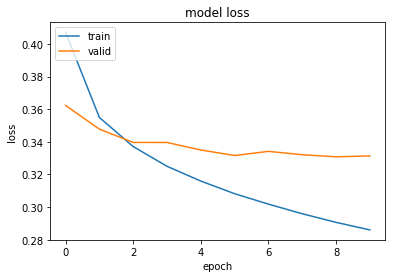

In [29]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [30]:
tb1_test = pd.read_csv("ratings_test.txt",sep='\t')

In [31]:
parsed_text = [mecab.morphs(str(i).strip()) for i in tb1_test['document']]

In [32]:
test_x = encoding_and_padding(parsed_text, keyword_dict, max_seq=int(max_seq))

In [33]:
test_y = tb1_test['label']

In [34]:
test_x.shape, test_y.shape

((50000, 19), (50000,))

In [35]:
prob = model.predict(test_x)

In [36]:
#개인적으로 모형 퍼포먼스 시각화는 R을 주로 활용하는편이다... ^^;..AUC 0.93정도로 꽤 좋은 성능이다.
%reload_ext rpy2.ipython

/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 필요한 패키지를 로딩중입니다: pROC

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Type 'citation("pROC")' for a citation.

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
다음의 패키지를 부착합니다: ‘pROC’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    cov, smooth, var


  warnings.warn(x, RRuntimeWarning)


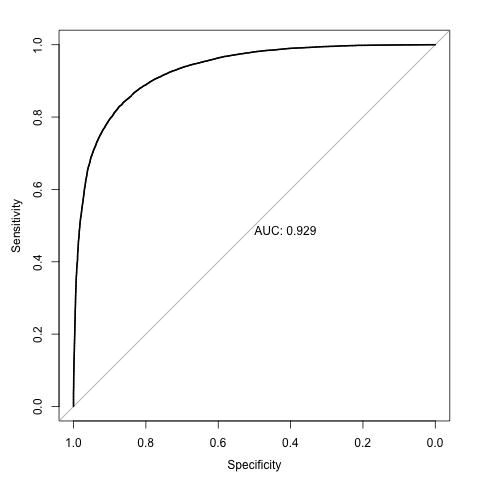

In [37]:
%%R -i test_y -i prob
require(pROC)
plot(roc(test_y, prob), print.auc=TRUE)

In [38]:
def grad_cam_conv1D(model, layer_nm, x, sample_weight=1,  keras_phase=0):
    import keras.backend as K
    import numpy as np
    
    #레이어 이름에 해당되는 레이어 정보를 가져옴 
    layers_wt = model.get_layer(layer_nm).weights
    layers = model.get_layer(layer_nm)
    layers_weights = model.get_layer(layer_nm).get_weights()
    
    #긍정 클래스를 설명할 수 있게 컨볼루션 필터 가중치의 gradient를 구함  
    grads = K.gradients(model.output[:,0], layers_wt)[0]
    
    #필터별로 가중치를 구함 
    pooled_grads = K.mean(grads, axis=(0,1))
    get_pooled_grads = K.function([model.input,model.sample_weights[0], K.learning_phase()], 
                         [pooled_grads, layers.output[0]])
    
    pooled_grads_value, conv_layer_output_value = get_pooled_grads([[x,], [sample_weight,], keras_phase])
    #다시한번 이야기 하지만 loss를 줄이기 위한 학습과정이 아니다... 
    for i in range(conv_layer_output_value.shape[-1]):
        conv_layer_output_value[:, i] *= pooled_grads_value[i]
    
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    return((heatmap, pooled_grads_value))

In [39]:
# test셋에서 90번째 인덱스에 해당하는 데이터를 시각화 해본다. 
idx = 90

In [40]:
prob[idx], tb1_test.iloc[idx], test_y[idx]

(array([0.01730378], dtype=float32),
 id                                                   9912932
 document    로코 굉장히 즐겨보는데, 이 영화는 좀 별로였다. 뭔가 사랑도 개그도 억지스런 느낌..
 label                                                      0
 Name: 90, dtype: object,
 0)

In [41]:
hm, graded = grad_cam_conv1D(model, 'conv1d_1', x=test_x[idx])

In [42]:
hm_tbl = pd.DataFrame({'heat':hm, 'kw':[keyword_rev_dict[i] for i in test_x[idx] ]})

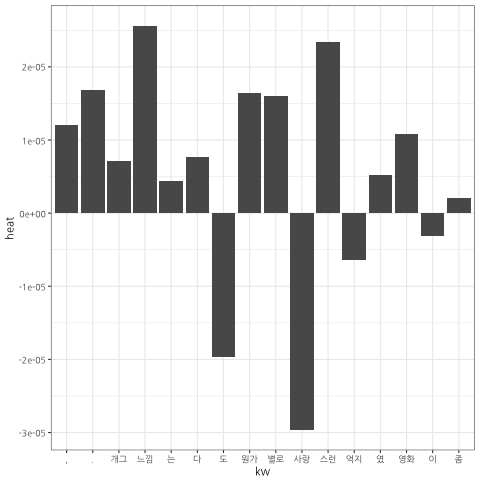

In [46]:
%%R -i hm_tbl
library(ggplot2)
library(extrafont)

ggplot(hm_tbl, aes(x=kw, y=heat)) + geom_bar(stat='identity') + theme_bw(base_family = 'NanumGothic')